In [1]:
!pip install recommenders surprise cornac==2.3.0 optuna==4.2.1 optuna-dashboard nbformat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 6.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.4/25.4 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.3/355.3 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.1 MB/

In [2]:
!add-apt-repository ppa:ubuntu-toolchain-r/test
!apt-get update
!apt-get install --only-upgrade libstdc++6

PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/ubuntu-toolchain-r/test/ubuntu/ jammy main'
Description:
Toolchain test builds; see https://wiki.ubuntu.com/ToolChain

More info: https://launchpad.net/~ubuntu-toolchain-r/+archive/ubuntu/test
Adding repository.
Press [ENTER] to continue or Ctrl-c to cancel.
Adding deb entry to /etc/apt/sources.list.d/ubuntu-toolchain-r-ubuntu-test-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/ubuntu-toolchain-r-ubuntu-test-jammy.list
Adding key to /etc/apt/trusted.gpg.d/ubuntu-toolchain-r-ubuntu-test.gpg with fingerprint C8EC952E2A0E1FBDC5090F6A2C277A0A352154E5
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy I

In [1]:
!cp '/content/drive/MyDrive/Final Project/Codes/animelist-goodbooks-recommendation/utils.py' .

In [2]:
import pandas as pd
import sys
import cornac
import recommenders
import optuna
import surprise

from recommenders.utils.timer import Timer
from recommenders.datasets.python_splitters import python_random_split
from recommenders.evaluation.python_evaluation import (
    ndcg_at_k,
    precision_at_k,
    recall_at_k,
)
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.utils.notebook_utils import store_metadata
from recommenders.models.cornac.cornac_utils import predict_ranking

from surprise import Dataset, NormalPredictor, Reader
from utils import compute_ranking_predictions

In [3]:
DATA_PATH = '/content/drive/MyDrive/Final Project/Codes/animelist-goodbooks-recommendation/goodbooks-10k/data_sample_split/'

In [4]:
train_data = pd.read_csv(f'{DATA_PATH}/data_train.tsv', sep='\t')
valid_data = pd.read_csv(f'{DATA_PATH}/data_valid.tsv', sep='\t')

In [5]:
train_data['time'] = pd.to_datetime(train_data["time"], utc=True)
valid_data['time'] = pd.to_datetime(valid_data["time"], utc=True)

In [8]:
SEED = 100

## Hyperparameter BPR

In [ ]:
class ObjectiveBPR(object):
    def __init__(self, train_data, valid_data):
        self.train_data = train_data
        self.valid_data = valid_data
        self.train_set = cornac.data.Dataset.from_uir(self.train_data[['user_id', 'book_id', 'rating']].itertuples(index=False), seed=SEED)

    def __call__(self, trial):

        factors = trial.suggest_int("factors", 20, 200, step=20)
        lr = trial.suggest_float("lr", 1e-3, 1e-1, log=True)
        lambda_reg = trial.suggest_float("lambda_reg", 1e-3, 1e-1, log=True)
        bpr = cornac.models.BPR(
            k=factors,
            max_iter=20,
            learning_rate=lr,
            lambda_reg=lambda_reg,
            verbose=True,
            seed=SEED
        )
        bpr.fit(self.train_set)
        all_predictions = predict_ranking(bpr, self.train_data, usercol='user_id', itemcol='book_id', remove_seen=True)
        ndcg_score = ndcg_at_k(self.valid_data, all_predictions, col_user="user_id", col_item="book_id", col_rating='rating', k=10)

        return ndcg_score

In [ ]:
objective = ObjectiveBPR(train_data, valid_data)
study_name = "goodbooks-bpr"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

study = optuna.create_study(direction="maximize", study_name=study_name, storage=storage_name)
study.optimize(objective, n_trials=50, n_jobs=-1)

[I 2025-04-15 05:01:41,570] A new study created in RDB with name: goodbooks-bpr


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!
Optimization finished!


[I 2025-04-15 05:02:51,571] Trial 0 finished with value: 0.06374903990844275 and parameters: {'factors': 160, 'lr': 0.0032067308410910034, 'lambda_reg': 0.0986584580873927}. Best is trial 0 with value: 0.06374903990844275.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:02:57,685] Trial 1 finished with value: 0.07594956270060525 and parameters: {'factors': 80, 'lr': 0.04434245627446954, 'lambda_reg': 0.08255712294247397}. Best is trial 1 with value: 0.07594956270060525.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:04:08,356] Trial 2 finished with value: 0.09220730745370088 and parameters: {'factors': 60, 'lr': 0.04794026769426136, 'lambda_reg': 0.002503741438209087}. Best is trial 2 with value: 0.09220730745370088.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:04:24,971] Trial 3 finished with value: 0.09311982783379047 and parameters: {'factors': 100, 'lr': 0.05563796962103741, 'lambda_reg': 0.00115831069114577}. Best is trial 3 with value: 0.09311982783379047.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:05:29,379] Trial 4 finished with value: 0.08344487074920189 and parameters: {'factors': 60, 'lr': 0.01735184280792091, 'lambda_reg': 0.001104622091819192}. Best is trial 3 with value: 0.09311982783379047.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-15 05:05:34,152] Trial 5 finished with value: 0.062138212691829495 and parameters: {'factors': 140, 'lr': 0.0016547395576618732, 'lambda_reg': 0.010017487348375754}. Best is trial 3 with value: 0.09311982783379047.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!
Optimization finished!


[I 2025-04-15 05:06:52,428] Trial 6 finished with value: 0.08500646399954642 and parameters: {'factors': 200, 'lr': 0.05042855431487028, 'lambda_reg': 0.024078185972487266}. Best is trial 3 with value: 0.09311982783379047.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-15 05:06:58,030] Trial 7 finished with value: 0.09463017973172132 and parameters: {'factors': 180, 'lr': 0.04050448179019407, 'lambda_reg': 0.001587447839258074}. Best is trial 7 with value: 0.09463017973172132.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!
Optimization finished!


[I 2025-04-15 05:08:06,296] Trial 8 finished with value: 0.060242632931679134 and parameters: {'factors': 200, 'lr': 0.0011040875676206455, 'lambda_reg': 0.006829844606555291}. Best is trial 7 with value: 0.09463017973172132.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-15 05:08:08,360] Trial 9 finished with value: 0.06115911954144546 and parameters: {'factors': 40, 'lr': 0.002545892291667662, 'lambda_reg': 0.03151659710742173}. Best is trial 7 with value: 0.09463017973172132.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!
Optimization finished!


[I 2025-04-15 05:09:20,221] Trial 10 finished with value: 0.07915129707983137 and parameters: {'factors': 20, 'lr': 0.034442441702204486, 'lambda_reg': 0.0672040216488721}. Best is trial 7 with value: 0.09463017973172132.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-15 05:09:26,531] Trial 11 finished with value: 0.07458388033351004 and parameters: {'factors': 140, 'lr': 0.013342281881022646, 'lambda_reg': 0.003579580124370229}. Best is trial 7 with value: 0.09463017973172132.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!
Optimization finished!


[I 2025-04-15 05:10:35,203] Trial 12 finished with value: 0.061739182940066646 and parameters: {'factors': 120, 'lr': 0.009675625221417893, 'lambda_reg': 0.0010600843680755071}. Best is trial 7 with value: 0.09463017973172132.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:10:51,961] Trial 13 finished with value: 0.09244614034381173 and parameters: {'factors': 100, 'lr': 0.09821808821282932, 'lambda_reg': 0.0010752165010713532}. Best is trial 7 with value: 0.09463017973172132.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:11:52,166] Trial 14 finished with value: 0.09307489502412825 and parameters: {'factors': 100, 'lr': 0.07909568245857855, 'lambda_reg': 0.002345059714895866}. Best is trial 7 with value: 0.09463017973172132.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:12:13,023] Trial 15 finished with value: 0.09780672242415187 and parameters: {'factors': 160, 'lr': 0.09948035935287367, 'lambda_reg': 0.0025362242876399398}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:13:07,305] Trial 16 finished with value: 0.08641632697913171 and parameters: {'factors': 180, 'lr': 0.023312831363630483, 'lambda_reg': 0.004918281449332643}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:13:32,341] Trial 17 finished with value: 0.08283948662636638 and parameters: {'factors': 180, 'lr': 0.018670310848154615, 'lambda_reg': 0.005238333553139028}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:14:15,758] Trial 18 finished with value: 0.06293902610652592 and parameters: {'factors': 160, 'lr': 0.005100093407854643, 'lambda_reg': 0.0021863910910742772}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:15:08,671] Trial 19 finished with value: 0.08933049446764064 and parameters: {'factors': 160, 'lr': 0.02851845197711505, 'lambda_reg': 0.002153969614727065}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:15:36,984] Trial 20 finished with value: 0.0634483613186862 and parameters: {'factors': 160, 'lr': 0.007708376602549007, 'lambda_reg': 0.01165465987416497}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:16:12,963] Trial 21 finished with value: 0.061803920865221094 and parameters: {'factors': 140, 'lr': 0.008826235147794282, 'lambda_reg': 0.013024700191322932}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:16:51,929] Trial 22 finished with value: 0.09466541359295931 and parameters: {'factors': 120, 'lr': 0.0586844131073621, 'lambda_reg': 0.0014858342488000902}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:02<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:17:29,568] Trial 23 finished with value: 0.09491879752669777 and parameters: {'factors': 120, 'lr': 0.07186992174344484, 'lambda_reg': 0.001667353739653498}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:18:16,197] Trial 24 finished with value: 0.09485367790355476 and parameters: {'factors': 120, 'lr': 0.07698351811708717, 'lambda_reg': 0.0016879019324497271}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:18:44,675] Trial 25 finished with value: 0.09431054183074782 and parameters: {'factors': 120, 'lr': 0.0764904040738542, 'lambda_reg': 0.003177324240674543}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:19:31,225] Trial 26 finished with value: 0.09442045433807059 and parameters: {'factors': 120, 'lr': 0.07909081265897511, 'lambda_reg': 0.003476766530636784}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:20:09,367] Trial 27 finished with value: 0.09115334426309118 and parameters: {'factors': 80, 'lr': 0.09243277549565435, 'lambda_reg': 0.004076422828567283}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:20:39,599] Trial 28 finished with value: 0.09078949443995395 and parameters: {'factors': 80, 'lr': 0.030262068076137617, 'lambda_reg': 0.0017933438967910015}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:21:19,214] Trial 29 finished with value: 0.08918834936229895 and parameters: {'factors': 140, 'lr': 0.02859579829172076, 'lambda_reg': 0.0016407715093834114}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:21:54,413] Trial 30 finished with value: 0.09042466178876302 and parameters: {'factors': 140, 'lr': 0.061949741895706234, 'lambda_reg': 0.00741804912710108}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:22:42,967] Trial 31 finished with value: 0.0883032596211798 and parameters: {'factors': 140, 'lr': 0.06707729461984872, 'lambda_reg': 0.017082249762305494}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:23:12,087] Trial 32 finished with value: 0.09524912204202406 and parameters: {'factors': 120, 'lr': 0.06447682554685906, 'lambda_reg': 0.001502184261235385}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:24:00,143] Trial 33 finished with value: 0.09406164102961491 and parameters: {'factors': 120, 'lr': 0.05557331250569005, 'lambda_reg': 0.0015430199443177283}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:24:34,662] Trial 34 finished with value: 0.09020462916269775 and parameters: {'factors': 100, 'lr': 0.04074538431906357, 'lambda_reg': 0.002752287686759117}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:25:26,574] Trial 35 finished with value: 0.0902540440659646 and parameters: {'factors': 100, 'lr': 0.0397810071741127, 'lambda_reg': 0.002813978928263346}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:26:03,205] Trial 36 finished with value: 0.09231436533471922 and parameters: {'factors': 80, 'lr': 0.09745730004502329, 'lambda_reg': 0.001417964593118207}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:26:31,722] Trial 37 finished with value: 0.09039929948282066 and parameters: {'factors': 60, 'lr': 0.09730715047636158, 'lambda_reg': 0.0019871047529450648}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:27:19,288] Trial 38 finished with value: 0.09269297315372571 and parameters: {'factors': 60, 'lr': 0.05006709571958589, 'lambda_reg': 0.0020518267733558404}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:27:49,031] Trial 39 finished with value: 0.09172137593452027 and parameters: {'factors': 160, 'lr': 0.046240036910240805, 'lambda_reg': 0.004456416332895416}. Best is trial 15 with value: 0.09780672242415187.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:28:28,800] Trial 40 finished with value: 0.09790718559539653 and parameters: {'factors': 160, 'lr': 0.06934795749035864, 'lambda_reg': 0.0011638948999349113}. Best is trial 40 with value: 0.09790718559539653.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:29:05,895] Trial 41 finished with value: 0.09823142693283318 and parameters: {'factors': 180, 'lr': 0.0664314073036339, 'lambda_reg': 0.0012791459230525816}. Best is trial 41 with value: 0.09823142693283318.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:29:54,801] Trial 42 finished with value: 0.09837847926851002 and parameters: {'factors': 180, 'lr': 0.06724248566659216, 'lambda_reg': 0.0012697886085559053}. Best is trial 42 with value: 0.09837847926851002.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:30:25,947] Trial 43 finished with value: 0.09552235076895392 and parameters: {'factors': 200, 'lr': 0.07207433706056017, 'lambda_reg': 0.0012577763608692643}. Best is trial 42 with value: 0.09837847926851002.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:31:13,677] Trial 44 finished with value: 0.09467663578128788 and parameters: {'factors': 200, 'lr': 0.0582618632556316, 'lambda_reg': 0.00133247393773277}. Best is trial 42 with value: 0.09837847926851002.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:31:43,239] Trial 45 finished with value: 0.09153060570381563 and parameters: {'factors': 200, 'lr': 0.035280361787411126, 'lambda_reg': 0.0012399279415314655}. Best is trial 42 with value: 0.09837847926851002.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:32:32,471] Trial 46 finished with value: 0.09359799861497042 and parameters: {'factors': 180, 'lr': 0.0351669695483211, 'lambda_reg': 0.001004758328272835}. Best is trial 42 with value: 0.09837847926851002.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:33:03,957] Trial 47 finished with value: 0.08773313075440067 and parameters: {'factors': 180, 'lr': 0.022928452486139773, 'lambda_reg': 0.0010148560691735278}. Best is trial 42 with value: 0.09837847926851002.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-15 05:33:50,824] Trial 48 finished with value: 0.08665136874055451 and parameters: {'factors': 180, 'lr': 0.021459134680401903, 'lambda_reg': 0.0012307106870117985}. Best is trial 42 with value: 0.09837847926851002.
[I 2025-04-15 05:34:07,462] Trial 49 finished with value: 0.09616412751367533 and parameters: {'factors': 180, 'lr': 0.0471245756009628, 'lambda_reg': 0.0012353223693515158}. Best is trial 42 with value: 0.09837847926851002.


In [ ]:
print(study.best_trial)

FrozenTrial(number=42, state=1, values=[0.09837847926851002], datetime_start=datetime.datetime(2025, 4, 15, 5, 28, 29, 618805), datetime_complete=datetime.datetime(2025, 4, 15, 5, 29, 54, 765664), params={'factors': 180, 'lr': 0.06724248566659216, 'lambda_reg': 0.0012697886085559053}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'factors': IntDistribution(high=200, log=False, low=20, step=20), 'lr': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'lambda_reg': FloatDistribution(high=0.1, log=True, low=0.001, step=None)}, trial_id=43, value=None)


In [ ]:
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print("Best Trial: ", study.best_trial)
print("Trials: ", study.trials)

Best params:  {'factors': 180, 'lr': 0.06724248566659216, 'lambda_reg': 0.0012697886085559053}
Best value:  0.09837847926851002
Best Trial:  FrozenTrial(number=42, state=1, values=[0.09837847926851002], datetime_start=datetime.datetime(2025, 4, 15, 5, 28, 29, 618805), datetime_complete=datetime.datetime(2025, 4, 15, 5, 29, 54, 765664), params={'factors': 180, 'lr': 0.06724248566659216, 'lambda_reg': 0.0012697886085559053}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'factors': IntDistribution(high=200, log=False, low=20, step=20), 'lr': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'lambda_reg': FloatDistribution(high=0.1, log=True, low=0.001, step=None)}, trial_id=43, value=None)
Trials:  [FrozenTrial(number=0, state=1, values=[0.06374903990844275], datetime_start=datetime.datetime(2025, 4, 15, 5, 1, 41, 598661), datetime_complete=datetime.datetime(2025, 4, 15, 5, 2, 51, 539998), params={'factors': 160, 'lr': 0.0032067308410910034, 'lambda_reg

### Visualization

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_contour(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_slice(study, params=["factors"])

In [ ]:
optuna.visualization.plot_slice(study, params=["lambda_reg"])

In [ ]:
optuna.visualization.plot_slice(study, params=["lr"])

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_edf(study)

In [ ]:
optuna.visualization.plot_rank(study)

In [ ]:
optuna.visualization.plot_timeline(study)

In [ ]:
optuna.visualization.plot_intermediate_values(study)

[W 2025-04-08 13:14:09,738] You need to set up the pruning feature to utilize `plot_intermediate_values()`


## Hyperparameter SVD

In [ ]:
class ObjectiveSVD(object):
    def __init__(self, train_data, valid_data):
      # A reader is still needed but only the rating_scale param is required.
      self.reader = Reader(rating_scale=(1, 10))
      self.train_data = train_data
      self.valid_data = valid_data
      self.train_set = Dataset.load_from_df(train_data[["user_id", "book_id", "rating"]], self.reader).build_full_trainset()

    def __call__(self, trial):

      n_factors = trial.suggest_int("n_factors", 20, 200, step=20)
      lr_all = trial.suggest_float("lr_all", 1e-3, 1e-1, log=True)
      reg_all = trial.suggest_float("reg_all", 1e-3, 1e-1, log=True)

      svd = surprise.SVD(random_state=SEED,
                         n_epochs=20,
                         verbose=False,
                         n_factors=n_factors,
                         lr_all = lr_all,
                         reg_all = reg_all
                         )
      svd.fit(self.train_set)

      all_predictions_svd = compute_ranking_predictions(
        svd, self.train_data, usercol="user_id", itemcol="book_id", predcol="prediction", remove_seen=True
      )

      ndcg_score = ndcg_at_k(self.valid_data, all_predictions_svd, col_user="user_id", col_item="book_id", col_rating='rating', k=10)

      return ndcg_score

In [ ]:
objective = ObjectiveSVD(train_data, valid_data)
study_name = "goodbooks-svd"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

study_svd = optuna.create_study(direction="maximize", study_name=study_name, storage=storage_name)
study_svd.optimize(objective, n_trials=50, n_jobs=-1)

[I 2025-04-15 05:44:26,950] A new study created in RDB with name: goodbooks-svd


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 05:51:26,093] Trial 0 finished with value: 0.01637803082315737 and parameters: {'n_factors': 80, 'lr_all': 0.01576926210444558, 'reg_all': 0.00978418348726331}. Best is trial 0 with value: 0.01637803082315737.
[I 2025-04-15 05:51:34,621] Trial 1 finished with value: 0.008142099824170995 and parameters: {'n_factors': 60, 'lr_all': 0.0027606811404721414, 'reg_all': 0.059672831776896945}. Best is trial 0 with value: 0.01637803082315737.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 05:58:03,520] Trial 3 finished with value: 0.015028795438597782 and parameters: {'n_factors': 20, 'lr_all': 0.0764207810144028, 'reg_all': 0.09442081820870851}. Best is trial 0 with value: 0.01637803082315737.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 05:58:17,565] Trial 2 finished with value: 0.008810244306136802 and parameters: {'n_factors': 140, 'lr_all': 0.0011728264169047248, 'reg_all': 0.027696245639697727}. Best is trial 0 with value: 0.01637803082315737.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 06:04:30,504] Trial 5 finished with value: 0.009634970905116136 and parameters: {'n_factors': 20, 'lr_all': 0.008348475404248707, 'reg_all': 0.09154274155961818}. Best is trial 0 with value: 0.01637803082315737.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 06:04:45,127] Trial 4 finished with value: 0.015776826405675667 and parameters: {'n_factors': 120, 'lr_all': 0.01853404449468605, 'reg_all': 0.04181159653342318}. Best is trial 0 with value: 0.01637803082315737.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 06:10:59,938] Trial 6 finished with value: 0.008873700205849867 and parameters: {'n_factors': 80, 'lr_all': 0.00495005174743689, 'reg_all': 0.05374240904929782}. Best is trial 0 with value: 0.01637803082315737.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 06:11:28,332] Trial 7 finished with value: 0.010062286456789409 and parameters: {'n_factors': 180, 'lr_all': 0.0024724280935625492, 'reg_all': 0.02435166830995867}. Best is trial 0 with value: 0.01637803082315737.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 06:17:28,588] Trial 8 finished with value: 0.014373149120847072 and parameters: {'n_factors': 200, 'lr_all': 0.03412497659424008, 'reg_all': 0.006194282012058239}. Best is trial 0 with value: 0.01637803082315737.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 06:17:53,114] Trial 9 finished with value: 0.007658133949041513 and parameters: {'n_factors': 160, 'lr_all': 0.001189676677711291, 'reg_all': 0.09790377681561716}. Best is trial 0 with value: 0.01637803082315737.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 06:23:56,784] Trial 10 finished with value: 0.018112466783535085 and parameters: {'n_factors': 160, 'lr_all': 0.031030379065107513, 'reg_all': 0.0014824444990968399}. Best is trial 10 with value: 0.018112466783535085.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 06:24:13,484] Trial 11 finished with value: 0.01807068008486234 and parameters: {'n_factors': 80, 'lr_all': 0.02413659588496486, 'reg_all': 0.0013051185003185946}. Best is trial 10 with value: 0.018112466783535085.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 06:30:34,979] Trial 12 finished with value: 0.018036339263992333 and parameters: {'n_factors': 80, 'lr_all': 0.026196175392853113, 'reg_all': 0.0011381057946586298}. Best is trial 10 with value: 0.018112466783535085.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 06:30:57,675] Trial 13 finished with value: 0.01685426617373379 and parameters: {'n_factors': 120, 'lr_all': 0.04882665714797507, 'reg_all': 0.0010250541015592084}. Best is trial 10 with value: 0.018112466783535085.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 06:37:01,240] Trial 14 finished with value: 0.0158592431210915 and parameters: {'n_factors': 120, 'lr_all': 0.0639689018460946, 'reg_all': 0.0011647411846771637}. Best is trial 10 with value: 0.018112466783535085.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 06:37:26,012] Trial 15 finished with value: 0.014226580753441895 and parameters: {'n_factors': 160, 'lr_all': 0.09482717541845927, 'reg_all': 0.00258438137810252}. Best is trial 10 with value: 0.018112466783535085.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 06:43:23,394] Trial 16 finished with value: 0.022077495938995752 and parameters: {'n_factors': 160, 'lr_all': 0.011245383354059084, 'reg_all': 0.002432844356011247}. Best is trial 16 with value: 0.022077495938995752.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 06:43:41,344] Trial 17 finished with value: 0.021962152189059694 and parameters: {'n_factors': 60, 'lr_all': 0.012823925991181737, 'reg_all': 0.0027683684449726497}. Best is trial 16 with value: 0.022077495938995752.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 06:50:20,710] Trial 19 finished with value: 0.026078123972173132 and parameters: {'n_factors': 40, 'lr_all': 0.009213099488892183, 'reg_all': 0.0035519384510889}. Best is trial 19 with value: 0.026078123972173132.
[I 2025-04-15 06:50:28,675] Trial 18 finished with value: 0.0201238468943405 and parameters: {'n_factors': 200, 'lr_all': 0.009774252328386747, 'reg_all': 0.003154706989879405}. Best is trial 19 with value: 0.026078123972173132.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 06:56:50,117] Trial 21 finished with value: 0.02185956989674778 and parameters: {'n_factors': 40, 'lr_all': 0.005681791297421786, 'reg_all': 0.005265310823455479}. Best is trial 19 with value: 0.026078123972173132.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 06:57:12,101] Trial 20 finished with value: 0.020015771097813932 and parameters: {'n_factors': 200, 'lr_all': 0.008540545809220609, 'reg_all': 0.0046583900929662875}. Best is trial 19 with value: 0.026078123972173132.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 07:02:56,787] Trial 22 finished with value: 0.02279219048009349 and parameters: {'n_factors': 40, 'lr_all': 0.0139039963875431, 'reg_all': 0.002349153828629293}. Best is trial 19 with value: 0.026078123972173132.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 07:03:25,101] Trial 23 finished with value: 0.020612031696795777 and parameters: {'n_factors': 40, 'lr_all': 0.016729262063440185, 'reg_all': 0.0028668079589330587}. Best is trial 19 with value: 0.026078123972173132.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 07:09:03,419] Trial 24 finished with value: 0.021101814247481407 and parameters: {'n_factors': 40, 'lr_all': 0.004462158248754829, 'reg_all': 0.0019798897276887824}. Best is trial 19 with value: 0.026078123972173132.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 07:09:43,811] Trial 25 finished with value: 0.02720493628410756 and parameters: {'n_factors': 100, 'lr_all': 0.005357095011406201, 'reg_all': 0.0021176441708757286}. Best is trial 25 with value: 0.02720493628410756.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 07:15:28,557] Trial 26 finished with value: 0.01932330916146504 and parameters: {'n_factors': 100, 'lr_all': 0.012292885853549384, 'reg_all': 0.00859457095619308}. Best is trial 25 with value: 0.02720493628410756.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 07:15:58,876] Trial 27 finished with value: 0.01628750331587376 and parameters: {'n_factors': 100, 'lr_all': 0.0035592352337064973, 'reg_all': 0.008873048983552928}. Best is trial 25 with value: 0.02720493628410756.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 07:21:50,720] Trial 28 finished with value: 0.017215199537792828 and parameters: {'n_factors': 60, 'lr_all': 0.003526243178317535, 'reg_all': 0.003996123188731004}. Best is trial 25 with value: 0.02720493628410756.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 07:22:20,280] Trial 29 finished with value: 0.026276706990351596 and parameters: {'n_factors': 60, 'lr_all': 0.006885024865595134, 'reg_all': 0.004042484372857138}. Best is trial 25 with value: 0.02720493628410756.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 07:27:45,228] Trial 30 finished with value: 0.015954785592182982 and parameters: {'n_factors': 20, 'lr_all': 0.006150722582997207, 'reg_all': 0.013832530279359788}. Best is trial 25 with value: 0.02720493628410756.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 07:28:31,751] Trial 31 finished with value: 0.01895535602117169 and parameters: {'n_factors': 100, 'lr_all': 0.00653316519480398, 'reg_all': 0.014294359430045953}. Best is trial 25 with value: 0.02720493628410756.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 07:33:48,463] Trial 32 finished with value: 0.02845702955292602 and parameters: {'n_factors': 60, 'lr_all': 0.0065919339870869256, 'reg_all': 0.0019789259444284264}. Best is trial 32 with value: 0.02845702955292602.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 07:34:29,249] Trial 33 finished with value: 0.013404154551965227 and parameters: {'n_factors': 60, 'lr_all': 0.0023240778021608576, 'reg_all': 0.0018793392006957465}. Best is trial 32 with value: 0.02845702955292602.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 07:40:23,044] Trial 34 finished with value: 0.012010159149706823 and parameters: {'n_factors': 60, 'lr_all': 0.001938417887725374, 'reg_all': 0.0018662182695659945}. Best is trial 32 with value: 0.02845702955292602.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 07:40:52,182] Trial 35 finished with value: 0.010912646633392248 and parameters: {'n_factors': 60, 'lr_all': 0.001655502538813885, 'reg_all': 0.0035556685933578235}. Best is trial 32 with value: 0.02845702955292602.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 07:46:27,665] Trial 36 finished with value: 0.025637796734812885 and parameters: {'n_factors': 80, 'lr_all': 0.006992316731548449, 'reg_all': 0.0037886252662794936}. Best is trial 32 with value: 0.02845702955292602.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 07:47:05,152] Trial 37 finished with value: 0.023984987324839138 and parameters: {'n_factors': 80, 'lr_all': 0.007511234783202179, 'reg_all': 0.005757942121719341}. Best is trial 32 with value: 0.02845702955292602.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 07:52:49,498] Trial 38 finished with value: 0.016258848926244913 and parameters: {'n_factors': 40, 'lr_all': 0.00395606988940458, 'reg_all': 0.006142171887957418}. Best is trial 32 with value: 0.02845702955292602.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 07:53:18,351] Trial 39 finished with value: 0.01331010377510841 and parameters: {'n_factors': 20, 'lr_all': 0.0037938771110052516, 'reg_all': 0.006910434100094946}. Best is trial 32 with value: 0.02845702955292602.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 07:58:50,511] Trial 40 finished with value: 0.0122822230350266 and parameters: {'n_factors': 20, 'lr_all': 0.0028880513276373703, 'reg_all': 0.0015795679600938645}. Best is trial 32 with value: 0.02845702955292602.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 07:59:35,341] Trial 41 finished with value: 0.021904416078029915 and parameters: {'n_factors': 140, 'lr_all': 0.009703361670489368, 'reg_all': 0.0015139107053221247}. Best is trial 32 with value: 0.02845702955292602.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 08:04:59,620] Trial 42 finished with value: 0.024784674644034343 and parameters: {'n_factors': 100, 'lr_all': 0.0053163179093784416, 'reg_all': 0.0041076441738199}. Best is trial 32 with value: 0.02845702955292602.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 08:05:44,413] Trial 43 finished with value: 0.023392854610243572 and parameters: {'n_factors': 80, 'lr_all': 0.005206255908652085, 'reg_all': 0.004188713207868784}. Best is trial 32 with value: 0.02845702955292602.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 08:11:33,508] Trial 44 finished with value: 0.016864822897843742 and parameters: {'n_factors': 80, 'lr_all': 0.020203050674847314, 'reg_all': 0.0034447033241466946}. Best is trial 32 with value: 0.02845702955292602.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 08:12:15,382] Trial 45 finished with value: 0.020208079912192478 and parameters: {'n_factors': 80, 'lr_all': 0.007210366261566145, 'reg_all': 0.011988126382898152}. Best is trial 32 with value: 0.02845702955292602.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 08:17:48,611] Trial 46 finished with value: 0.021395931627464854 and parameters: {'n_factors': 60, 'lr_all': 0.008477834205244327, 'reg_all': 0.011664954953100987}. Best is trial 32 with value: 0.02845702955292602.


  0%|          | 0/10000 [00:00<?, ?it/s]

[I 2025-04-15 08:18:33,925] Trial 47 finished with value: 0.027754487300024187 and parameters: {'n_factors': 60, 'lr_all': 0.008477182106410673, 'reg_all': 0.0019890002717715084}. Best is trial 32 with value: 0.02845702955292602.


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
print(study_svd.best_trial)

FrozenTrial(number=32, state=1, values=[0.02845702955292602], datetime_start=datetime.datetime(2025, 4, 15, 7, 27, 45, 244438), datetime_complete=datetime.datetime(2025, 4, 15, 7, 33, 48, 426510), params={'n_factors': 60, 'lr_all': 0.0065919339870869256, 'reg_all': 0.0019789259444284264}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_factors': IntDistribution(high=200, log=False, low=20, step=20), 'lr_all': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'reg_all': FloatDistribution(high=0.1, log=True, low=0.001, step=None)}, trial_id=33, value=None)


In [ ]:
print("Best params: ", study_svd.best_params)
print("Best value: ", study_svd.best_value)
print("Best Trial: ", study_svd.best_trial)
print("Trials: ", study_svd.trials)

Best params:  {'n_factors': 60, 'lr_all': 0.0065919339870869256, 'reg_all': 0.0019789259444284264}
Best value:  0.02845702955292602
Best Trial:  FrozenTrial(number=32, state=1, values=[0.02845702955292602], datetime_start=datetime.datetime(2025, 4, 15, 7, 27, 45, 244438), datetime_complete=datetime.datetime(2025, 4, 15, 7, 33, 48, 426510), params={'n_factors': 60, 'lr_all': 0.0065919339870869256, 'reg_all': 0.0019789259444284264}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_factors': IntDistribution(high=200, log=False, low=20, step=20), 'lr_all': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'reg_all': FloatDistribution(high=0.1, log=True, low=0.001, step=None)}, trial_id=33, value=None)
Trials:  [FrozenTrial(number=0, state=1, values=[0.01637803082315737], datetime_start=datetime.datetime(2025, 4, 15, 5, 44, 26, 966698), datetime_complete=datetime.datetime(2025, 4, 15, 5, 51, 26, 50585), params={'n_factors': 80, 'lr_all': 0.015769262104445

### Visualization

In [ ]:
optuna.visualization.plot_optimization_history(study_svd)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study_svd)

In [ ]:
optuna.visualization.plot_contour(study_svd)

In [ ]:
optuna.visualization.plot_slice(study_svd)

In [ ]:
optuna.visualization.plot_slice(study_svd, params=["n_factors"])

In [ ]:
optuna.visualization.plot_slice(study_svd, params=["lr_all"])

In [ ]:
optuna.visualization.plot_slice(study_svd, params=["reg_all"])

In [ ]:
optuna.visualization.plot_param_importances(study_svd)

In [ ]:
optuna.visualization.plot_edf(study_svd)

In [ ]:
optuna.visualization.plot_rank(study_svd)

In [ ]:
optuna.visualization.plot_timeline(study_svd)

## Epoch Parameter BPR

In [9]:
train_data_full = pd.read_csv(f'{DATA_PATH}/data_train_full.tsv', sep='\t')
test_data = pd.read_csv(f'{DATA_PATH}/data_test.tsv', sep='\t')

In [10]:
eval_method = cornac.eval_methods.BaseMethod.from_splits(
  train_data=list(train_data_full[['user_id', 'book_id', 'rating']].itertuples(index=False)),
  test_data=list(test_data[['user_id', 'book_id', 'rating']].itertuples(index=False)),
  exclude_unknowns=True,
  verbose=True,
  seed=SEED,
)

rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 10000
Number of items = 1000
Number of ratings = 462630
Max rating = 5.0
Min rating = 3.0
Global mean = 4.1
---
Test data:
Number of users = 10000
Number of items = 1000
Number of ratings = 115607
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 10000
Total items = 1000


In [11]:
from tqdm.notebook import tqdm
import time

In [12]:
epoch_result_bpr = {}

In [13]:
# Best params:  {'factors': 180, 'lr': 0.06724248566659216, 'lambda_reg': 0.0012697886085559053}

for epoch in tqdm(range(10,210,10)):

  bpr = cornac.models.BPR(
    k=180,
    max_iter=epoch,
    learning_rate=0.0672,
    lambda_reg=0.0013,
    verbose=True,
    seed=SEED
  )
  start_time = time.time()
  bpr.fit(eval_method.train_set)
  train_time = time.time() - start_time

  start_time = time.time()
  all_predictions = predict_ranking(bpr, train_data_full, usercol='user_id', itemcol='book_id', remove_seen=True)
  prediction_time = time.time() - start_time

  ndcg_score = ndcg_at_k(test_data, all_predictions, col_user="user_id", col_item="book_id", col_rating='rating', k=10)
  epoch_result_bpr[epoch] = {'ndcg':ndcg_score, 'train_time': train_time, 'prediction_time': prediction_time}


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/30 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/40 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/60 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/70 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/80 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/90 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/110 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/120 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/130 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/140 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/150 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/160 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/170 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/180 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/190 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/200 [00:00<?, ?it/s]

Optimization finished!


In [14]:
epoch_df = pd.DataFrame(epoch_result_bpr).T.reset_index()

In [15]:
epoch_df = epoch_df.rename(columns={"index":"epoch"})

In [16]:
epoch_df

,epoch,ndcg,train_time,prediction_time
0,10,0.088536,3.202848,16.417928
1,20,0.096711,6.222733,17.673781
2,30,0.099570,9.879658,14.985234
3,40,0.099908,12.238268,15.360880
4,50,0.102260,16.747079,17.512982
5,60,0.103588,19.415197,16.252319
6,70,0.104177,23.093246,15.861053
7,80,0.105558,25.619712,15.311984
8,90,0.105516,30.067273,15.452043
9,100,0.106467,31.595267,19.276017


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

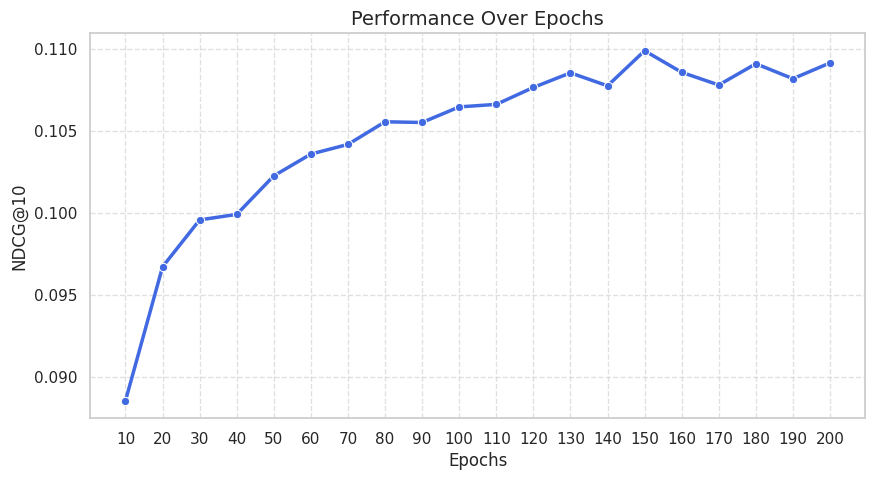

In [18]:
sns.set(style="whitegrid")

# Plot 1: Performance vs. Epochs
plt.figure(figsize=(10, 5))
sns.lineplot(data=epoch_df, x="epoch", y="ndcg", marker="o", linewidth=2.5, color="royalblue")
plt.title("Performance Over Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("NDCG@10", fontsize=12)
plt.xticks(epoch_df["epoch"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

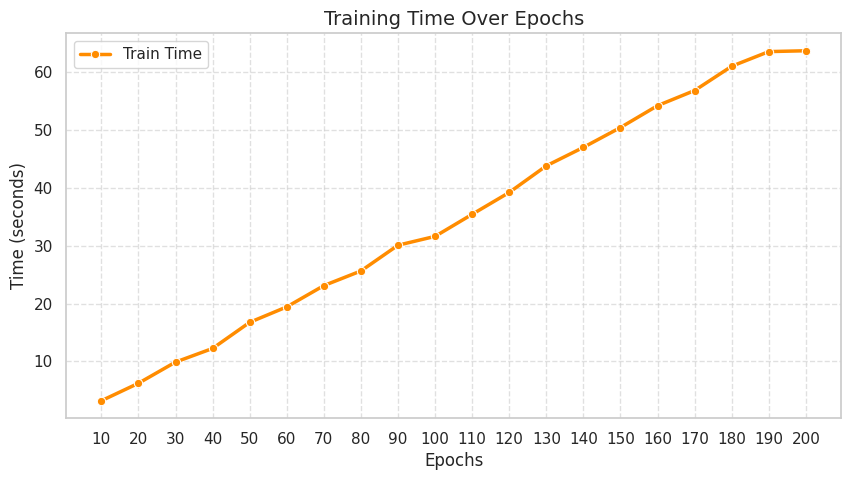

In [19]:
# Plot 2: Train Time & Prediction Time vs. Epochs
plt.figure(figsize=(10, 5))
sns.lineplot(data=epoch_df, x="epoch", y="train_time", marker="o", linewidth=2.5, label="Train Time", color="darkorange")
plt.title("Training Time Over Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Time (seconds)", fontsize=12)
plt.xticks(epoch_df["epoch"])
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

## Epoch Parameter SVD

In [ ]:
epoch_result_svd = {}

In [ ]:
reader = Reader(rating_scale=(1, 10))
svd_train_set = Dataset.load_from_df(train_data_full[["user_id", "book_id", "rating"]], reader).build_full_trainset()

In [ ]:
# Best params:  {'n_factors': 60, 'lr_all': 0.0065919339870869256, 'reg_all': 0.0019789259444284264}

for epoch in tqdm(range(10,210,10)):

  svd = surprise.SVD(random_state=SEED,
                         n_epochs=epoch,
                         verbose=False,
                         n_factors=60,
                         lr_all = 0.0066,
                         reg_all = 0.0020
                         )

  start_time = time.time()
  svd.fit(svd_train_set)
  train_time = time.time() - start_time

  start_time = time.time()
  all_predictions_svd = compute_ranking_predictions(
    svd, train_data_full, usercol="user_id", itemcol="book_id", predcol="prediction", remove_seen=True
  )
  prediction_time = time.time() - start_time

  ndcg_score = ndcg_at_k(test_data, all_predictions_svd, col_user="user_id", col_item="book_id", col_rating='rating', k=10)
  epoch_result_svd[epoch] = {'ndcg':ndcg_score, 'train_time': train_time, 'prediction_time': prediction_time}


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
epoch_df = pd.DataFrame(epoch_result_svd).T.reset_index()

In [ ]:
epoch_df = epoch_df.rename(columns={"index":"epoch"})

In [ ]:
epoch_df

,epoch,ndcg,train_time,prediction_time
0,10,0.023137,2.211418,144.082022
1,20,0.029641,3.533813,119.935758
2,30,0.026659,6.886056,122.397224
3,40,0.024082,8.598554,118.911231
4,50,0.022741,10.266210,130.154236
5,60,0.021689,12.067303,120.185150
6,70,0.021236,13.426057,116.729724
7,80,0.020728,15.325558,116.603369
8,90,0.020134,25.164060,122.443577
9,100,0.019799,20.057450,114.327643


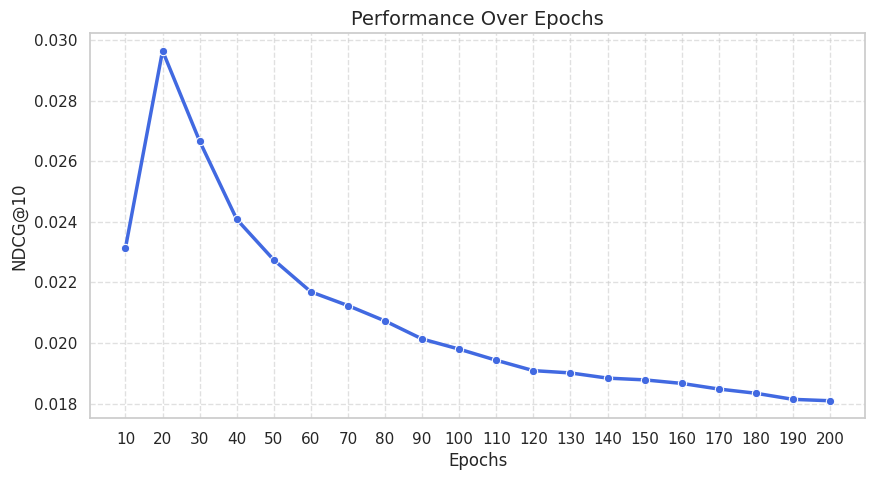

In [ ]:
sns.set(style="whitegrid")

# Plot 1: Performance vs. Epochs
plt.figure(figsize=(10, 5))
sns.lineplot(data=epoch_df, x="epoch", y="ndcg", marker="o", linewidth=2.5, color="royalblue")
plt.title("Performance Over Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("NDCG@10", fontsize=12)
plt.xticks(epoch_df["epoch"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

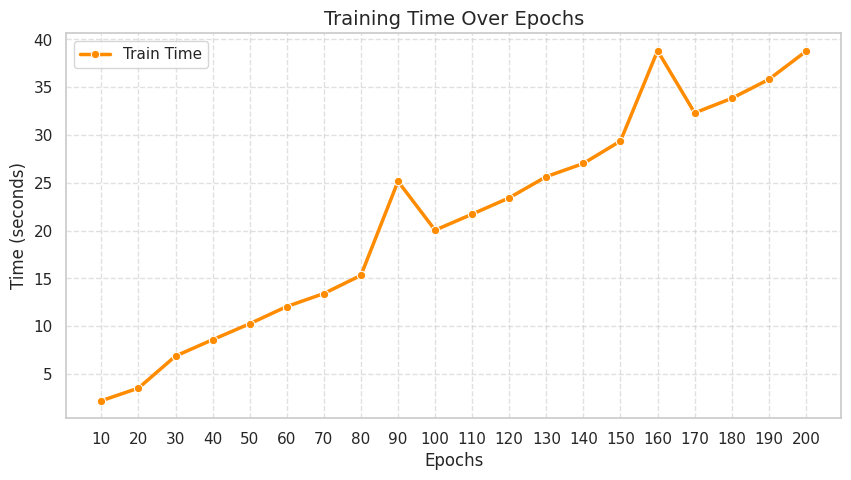

In [ ]:
# Plot 2: Train Time & Prediction Time vs. Epochs
plt.figure(figsize=(10, 5))
sns.lineplot(data=epoch_df, x="epoch", y="train_time", marker="o", linewidth=2.5, label="Train Time", color="darkorange")
plt.title("Training Time Over Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Time (seconds)", fontsize=12)
plt.xticks(epoch_df["epoch"])
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()